In [2]:
# Install all the necesary packages
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.cm as cm
%matplotlib notebook
from random import shuffle

In [3]:
# Gini coefficient is needed to evaluate the performance of different strategies
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    for i in range(len(array)):
        array[i] += 0.0000001 # Values cannot be 0
    array = np.sort(array) # Values must be sorted
    index = np.arange(1,array.shape[0]+1) # Index per array element
    n = array.shape[0]# Number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) # Gini coefficient

In [4]:
class Simulation(object):
    """A Simulation of a robotic vacuum cleaner that automatically moves
    around a room to clean the floor. The room is modelled as a 2-D grid with walls
    which surround it and several obstacles (furniture). The simulation implements
    three strategies: clever, random, and mixed. They are compared to each other 
    against several metrics including the Gini coefficient, time it takes
    to clean each tile at least once, and  a max/min/average number of times the
    tile was cleaned. 
    """

    def __init__(self, size, probobst = 0.1, strategy= "random", cleaned_once = True):
        """ This function initializes an instance of the simulation.
        Inputs:
            size (int) - the length of the square room.
            probobst (float) - the probability of an obstacle in the room.
            strategy (str) - "random", "clever", or "mixed" which corresponds
                to a specific strategy Roomba follows.
            cleaned_once (boolean) - if True, the simulation stops after each tile
                has been cleaned at least once.
        Outputs:
            The simulation returns true when the floor was cleaned and can
            produce visualizations of the Roomba in the room and the metrics.
        """
        self.size = size
        self.time = 0 # Calculates the number of updates
        self.grid = [[0 for i in range(size)] for j in range(size)] # Initializes a square room
        self.probobst = probobst
        self.strategy = strategy
        self.possible_ways = [] # The directions Roomba can move to
        self.gini = [] 
        self.maximums = []
        self.minimums = []
        self.averages = []
        self.cleaned_once = cleaned_once
        for i in range(len(self.grid)):
            for j in range(len(self.grid[i])):
                # Initializes walls
                if i == 0 or j == 0 or i == (self.size - 1) or j == (self.size - 1):
                    self.grid[i][j] = -50
                # Initializes obstacles
                if random.random() < self.probobst:
                    self.grid[i][j] = -50
        # Random initial position of Roomba
        self.pos = [np.random.randint(0,size-1), np.random.randint(0,size-1)]
        while self.grid[self.pos[0]][self.pos[1]] == -50:
            self.pos = [np.random.randint(0,size-1), np.random.randint(0,size-1)]

    # Visualizations    
    def observe(self): 
        """ A function that visializes the movement of Roombain the room."""
        plt.clf()
        # The room with the vacuum cleaner
        plt.subplot(1,2,1)
        plt.axis("off")
        plt.title('Timestep: %s'%self.time)
        plt.imshow(self.grid, cmap = cm.magma)
        plt.scatter(self.pos[1], self.pos[0], c = "green")
        plt.subplot(1,2,2)
        # A histogram with the number of times tiles were cleaned
        plt.title('Number of Times Tiles Were Cleaned')
        plt.hist(self.distribution())
        plt.show()
        
    def metrics(self): 
        plt.clf()
        # Plots max, min, and mean
        plt.subplot(1,2,1)
        plt.title('Metrics')
        plt.plot(self.maximums, label = "Maximum")
        plt.plot(self.minimums, label = "Minimum")
        plt.plot(self.averages, label = "Mean")
        plt.legend(loc = "upper left")
        # Plots how Gini coefficient changes over time
        plt.subplot(1,2,2)
        plt.title('Gini Coefficient')
        plt.plot(self.gini)
        plt.show()
        
    def check_for_obst(self):
        """This function checks the directions (up, down, left, right)
        Roomba can move into. In case there is an obstacle on the way,
        the function removes this direction from self.possible_ways.
        """ 
        possible_ways = []
        for i in [-1,1]:
            if self.grid[self.pos[0]+i][self.pos[1]] != -50:
                possible_ways.append([self.pos[0]+i, self.pos[1]])
            if self.grid[self.pos[0]][self.pos[1]+i] != -50:
                possible_ways.append([self.pos[0], self.pos[1]+i])
        self.possible_ways = possible_ways
    
    # Strategies
    def random_str(self):
        """ Roomba chooses one of the possible directions randomly."""
        self.check_for_obst()
        move = random.choice(self.possible_ways)
        self.pos = move
        
    def clever_str(self):
        """ Roomba moves in the direction which was cleaned the least
        number of times, if there are multiple options, it chooses the
        direction in a specific order they follow in the possible_ways.
        """
        self.check_for_obst()
        value = 100
        move = 0
        for i in self.possible_ways:
            if value > self.grid[i[0]][i[1]]:
                value = self.grid[i[0]][i[1]]
                move = i
        self.pos = move  
    
    def mixed_str(self):
        """ Roomba moves in the direction which was cleaned the least
        number of times, if there are multiple options, it chooses the
        direction randomly.
        """
        self.check_for_obst()
        value = 100
        move = 0
        random_ways = random.sample(self.possible_ways, len(self.possible_ways)) 
        for i in random_ways:
            if value > self.grid[i[0]][i[1]]:
                value = self.grid[i[0]][i[1]]
                move = i
        self.pos = move   
    
    def update(self):
        """ This function moves the vacuum cleaner one tile forward
        based on the strategy the user has identified, updates self.time,
        and calculates the metrics for each step. It returns true if all
        tiles have been cleaned at least once.
        """
        #Check if the floor is clean
        if self.cleaned_once == True:
            if 0 not in self.distribution():
                return True
        # Combined strategy uses random and clever strategies 50% of the times
        if self.strategy == "combined":
            if random.random() < 0.5:
                self.strategy = "clever"
            else:
                self.strategy = "random"
        if self.strategy == "random":
            self.random_str()
            self.grid[self.pos[0]][self.pos[1]] = self.grid[self.pos[0]][self.pos[1]] + 1
            self.grid[self.pos[0]][self.pos[1]] = self.grid[self.pos[0]][self.pos[1]] + 1
        if self.strategy == "clever":
            self.clever_str()
            self.grid[self.pos[0]][self.pos[1]] = self.grid[self.pos[0]][self.pos[1]] + 1
        if self.strategy == "mixed":
            self.clever_str()
            self.grid[self.pos[0]][self.pos[1]] = self.grid[self.pos[0]][self.pos[1]] + 1
        self.gini.append(self.gini_coef())
        self.maximums.append(self.maxim())
        self.minimums.append(self.minim())
        self.averages.append(self.average())
        self.time += 1
        
    def distribution(self):
        # Returns a list with the number of times each tile has been cleaned.
        flattened = []
        for i in range(len(self.grid)):
            for j in range(len(self.grid[i])):
                if self.grid[i][j] >= 0:
                    flattened.append(self.grid[i][j])
        return flattened

    # Metrics   
    def gini_coef(self):
        # Calculates gini coefficient
        gini_coef = gini(self.distribution())
        return gini_coef

    def maxim(self):
        # Calculates max number of times a tile was cleaned
        maximum = max(self.distribution())
        return maximum
    
    def minim(self):
        # Calculates min number of times a tile was cleaned
        minimum = min(self.distribution())
        return minimum

    def average(self):
        # Calculates average number of times a tile was cleaned
        mean = np.mean(self.distribution())
        return mean

<IPython.core.display.Javascript object>


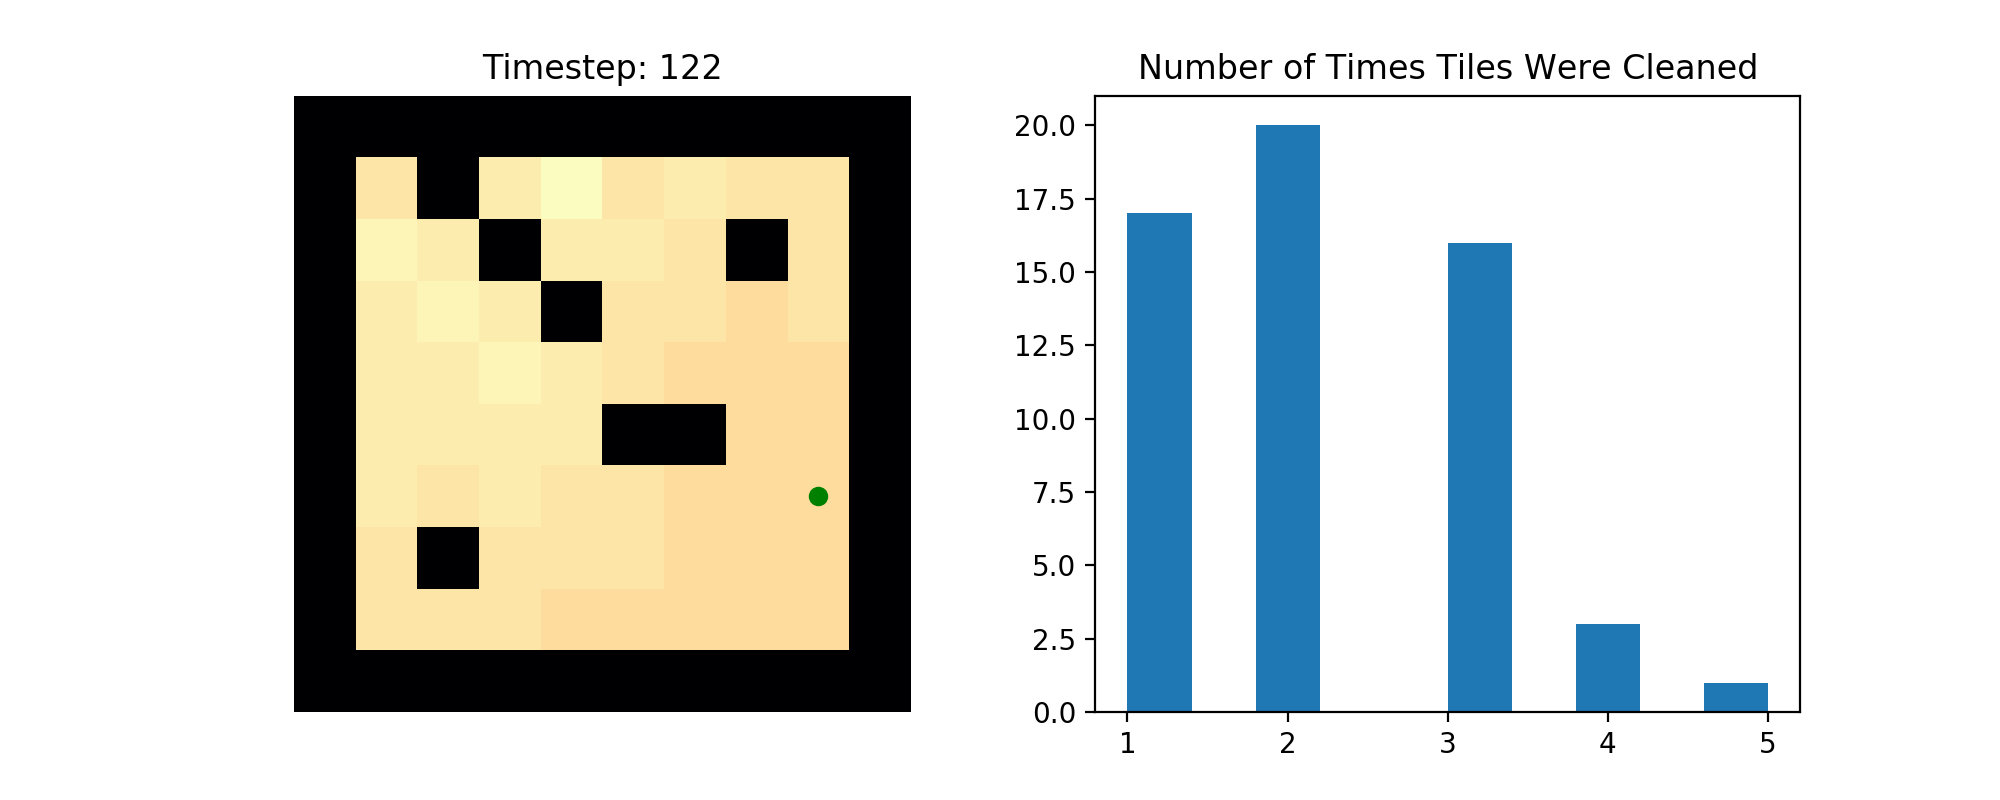

In [10]:
%matplotlib notebook

test = Simulation(10,0.1, strategy= "clever") # Strategy can be changed

fig = plt.figure(figsize=(10,4))
plt.axis("off")

def animate(i):
    """ Creates an animation."""
    for t in range(50): # Can be changed to speed up the update process.
        test.update()
        test.observe()
    
ani = animation.FuncAnimation(fig, animate, 
                frames=100, interval=500,blit=True,repeat=True) 


Clever Strategy


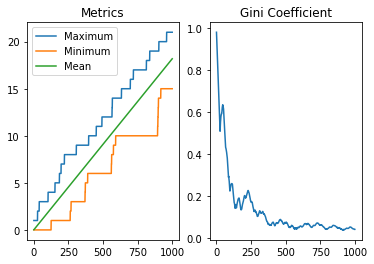

Random Strategy


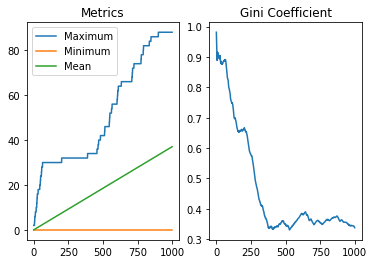

Mixed Strategy


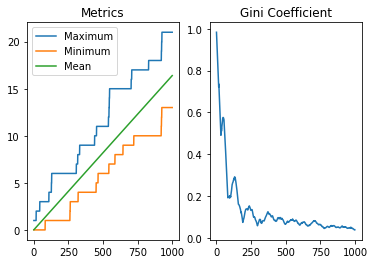

Combined Strategy


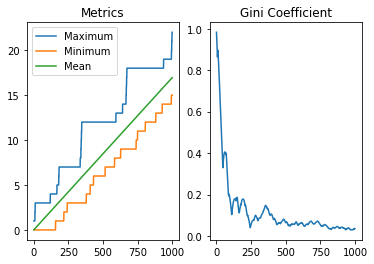

In [12]:
%matplotlib inline

# Visualize the metrics to analyze different strategies
print "Clever Strategy"
test = Simulation(10,0.1, strategy= "clever", cleaned_once = False)
for i in range(1000):
    test.update()
test.metrics()

print "Random Strategy"
test = Simulation(10,0.1, strategy= "random", cleaned_once = False)
for i in range(1000):
    test.update()
test.metrics()

print "Mixed Strategy"
test = Simulation(10,0.1, strategy= "mixed", cleaned_once = False)
for i in range(1000):
    test.update()
test.metrics()

print "Combined Strategy"
test = Simulation(10,0.1, strategy= "combined", cleaned_once = False)
for i in range(1000):
    test.update()
test.metrics()

In [22]:
# Create a list of time steps it takes Roomba to
# clean each time of the floor once (Mixed strategy)
times_mixed =[]
for i in range(100):
    test = Simulation(10,0.1, strategy= "mixed")
    for j in range(1000):
        test.update()
        if test.update() == True:
            times_mixed.append(test.time)
            break       
            
# This piece of code sometimes breaks which might happen
# because in some cases the floor is never cleaned
# since the obstacles are distributed in a way
# that makes it impossible for the vacuum cleaner to
# get into some places (separates the room into 2 parts).

In [19]:
# Create a list of time steps it takes Roomba to
# clean each time of the floor once (Random strategy)
times_random =[]
for i in range(100):
    test = Simulation(10,0.1, strategy= "random")
    for j in range(1000):
        test.update()
        if test.update() == True:
            times_random.append(test.time)
            break       

In [15]:
# Create a list of time steps it takes Roomba to
# clean each time of the floor once (Clever strategy)
times_clever =[]
for i in range(100):
    test = Simulation(10,0.1, strategy= "clever")
    for j in range(1000):
        test.update()
        if test.update() == True:
            times_clever.append(test.time)
            break     

In [23]:
#print "Confidence Interval for the Random Strategy:", stats.t.interval(0.95, len(times_random)-1, loc=np.mean(times_random), scale=stats.sem(times_random))        
print "Confidence Interval for the Mixed Strategy:", stats.t.interval(0.95, len(times_mixed)-1, loc=np.mean(times_mixed), scale=stats.sem(times_mixed))        
#print "Confidence Interval for the Clever Strategy:", stats.t.interval(0.95, len(times_clever)-1, loc=np.mean(times_clever), scale=stats.sem(times_clever))        
stats.describe(times_mixed)

Confidence Interval for the Mixed Strategy: (127.72740197208633, 143.44785575987243)


DescribeResult(nobs=97, minmax=(63, 235), mean=135.58762886597938, variance=1520.9948453608247, skewness=0.04068946326037552, kurtosis=-0.6535942843293729)

In [27]:
# Statistics
print "Random"
print stats.describe(times_random)
print "Mixed"
print stats.describe(times_mixed)
print "Clever"
print stats.describe(times_clever)

Random
DescribeResult(nobs=98, minmax=(322, 1976), mean=743.8367346938776, variance=103782.11739953714, skewness=1.2258392810940264, kurtosis=1.702406254411719)
Mixed
DescribeResult(nobs=97, minmax=(63, 235), mean=135.58762886597938, variance=1520.9948453608247, skewness=0.04068946326037552, kurtosis=-0.6535942843293729)
Clever
DescribeResult(nobs=95, minmax=(58, 203), mean=131.09473684210528, variance=1299.5760358342666, skewness=0.0025475385074511126, kurtosis=-0.8214631087332207)
